# Visualize Texas vaccination efforts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
county = "Statewide"

## Daily vaccine dose administration

Load cumulative data and calculate daily changes in total doses administered

In [3]:
df = pd.read_csv("docs/vaccine/data.csv", index_col=['county', 'date'], parse_dates=['date'])
df_diff = pd.DataFrame(df.loc[county, 'total_doses']).diff()
df_diff.iloc[0] = df.loc[county, 'total_doses'][0] # Replace NaN value on first day with first total value
df_diff.rename(columns={"total_doses": "daily_doses"}, inplace=True)

Calculate 7-day simple moving average

In [4]:
window = 7
df_diff['daily_doses_avg'] = df_diff.rolling(window=window, min_periods=1).mean()

Calculate 14-day trendline

In [5]:
n = 14
x = np.arange(0,n)
coef = np.polyfit(x, df_diff['daily_doses'][-n:], 1)
poly1d_fnc = np.poly1d(coef)

Plot

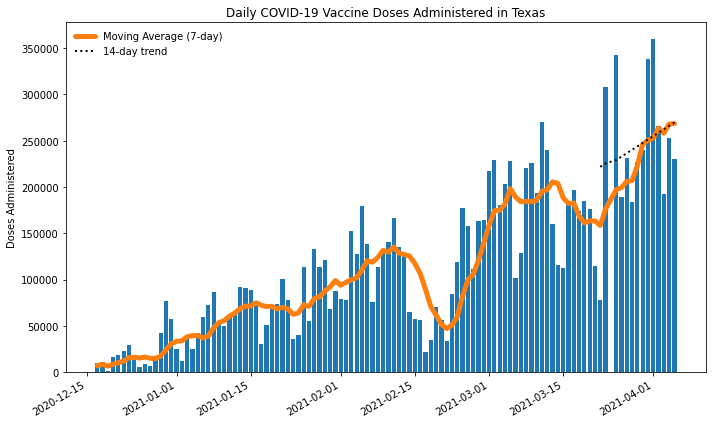

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(df_diff.index[:-1], df_diff['daily_doses'][1:])
plt.plot(df_diff.index[:-1], df_diff['daily_doses_avg'][1:], color="C1", linewidth=5, 
         solid_capstyle="round", label=f"Moving Average ({window}-day)")
plt.plot(df_diff.index[-n-1:-1], poly1d_fnc(x), ':k', linewidth=2, label=f"{n}-day trend")
fig.autofmt_xdate()
plt.ylabel("Doses Administered")
if county == "Statewide":
    plt.title("Daily COVID-19 Vaccine Doses Administered in Texas")
else:
    plt.title(f"Daily COVID-19 Vaccine Doses Administered in {county} County")
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig(f"DailyDoses_{county}.png", dpi=300, facecolor="w", transparent=False)

In [7]:
dose_rate = df_diff['daily_doses_avg'][-1]
print(f"The dose administration rate over the last week was {dose_rate:0,.0f} doses per day.\n" +
      f"At this rate, it will take about {1e6/dose_rate:0.1f} days to administer the next one million doses.")

The dose administration rate over the last week was 268,540 doses per day.
At this rate, it will take about 3.7 days to administer the next one million doses.


## Estimate Janssen (Johnson & Johnson) Vaccine Use

Load data and calculate discrepancy between number of people vaccinated, number of
people with at least one dose, and total number of doses administered to estimate the
number of people that have received Janssen vaccine

In [8]:
df = pd.read_csv("docs/vaccine/data.csv", index_col=['county', 'date'], parse_dates=['date'])
df = df.loc[county, :]
df['pfizer_moderna_first'] = df['total_doses'] - df['vaccinated']
df['pfizer_moderna_second'] = df['total_doses'] - df['one_dose']
df['janssen'] = df['one_dose'] + df['vaccinated'] - df['total_doses']
df.loc[df.index < "2021-03-01", "janssen"] = 0 # Zero all values prior to the first Janssen vaccine distribution

Plot

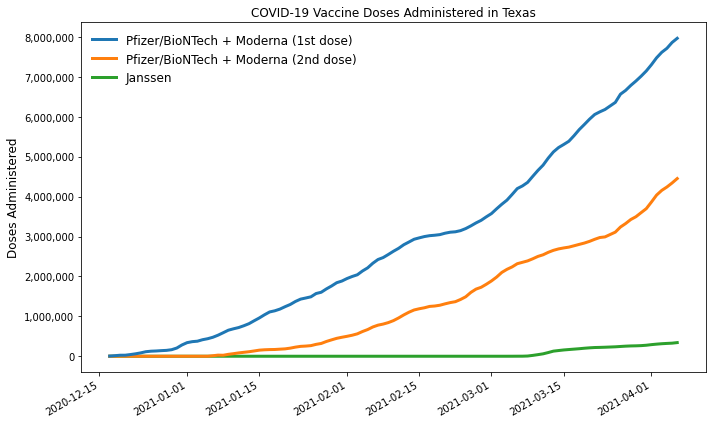

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df.index, df['pfizer_moderna_first'], linewidth=3, label="Pfizer/BioNTech + Moderna (1st dose)", zorder=3)
plt.plot(df.index, df['pfizer_moderna_second'], linewidth=3, label="Pfizer/BioNTech + Moderna (2nd dose)", zorder=2)
plt.plot(df.index, df['janssen'], linewidth=3, label="Janssen", zorder=1)
fig.autofmt_xdate()
plt.ylabel("Doses Administered", fontsize=12)
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
if county == "Statewide":
    plt.title("COVID-19 Vaccine Doses Administered in Texas")
else:
    plt.title(f"COVID-19 Vaccine Doses Administered in {county} County")
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
# plt.savefig(f"DoseKind_{county}.png", dpi=300, facecolor="w", transparent=False)

In [10]:
pct_janssen = df.iloc[-1]['janssen'] / df.iloc[-1]['vaccinated']
print(f"People vaccinated with Janssen ({df.iloc[-1]['janssen']:0,.0f}) currently account for " +
      f"{pct_janssen:0.2%} of all complete vaccinations ({df.iloc[-1]['vaccinated']:0,.0f})")

People vaccinated with Janssen (341,903) currently account for 7.13% of all complete vaccinations (4,793,909)
